In [2]:
# Importing libraries
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm

In [3]:
# Reading the dataset
train_dir = './train/'
test_dir = './test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

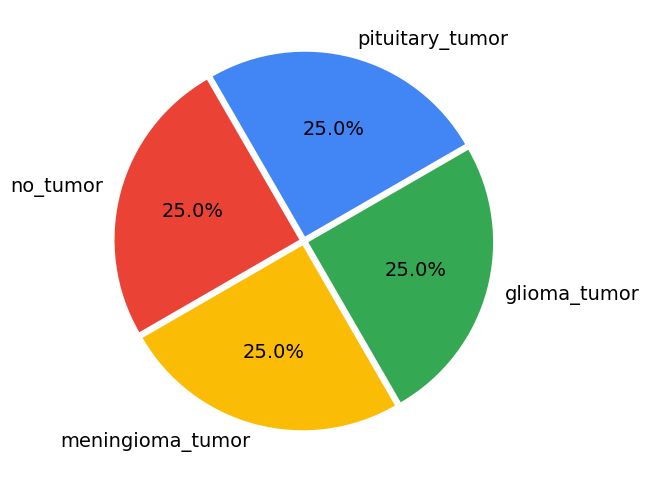

In [4]:
# Visualizing the balance of the training set
class_labels = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
class_counts = []

for class_name in class_labels:
    class_dir = os.path.join(train_dir, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)

colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})
plt.pie(class_counts, labels=class_labels, colors=colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025), startangle=30)
plt.show()

In [5]:
# Data Augmentation
IMAGE_SIZE = 128

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

In [6]:
# Opening images
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Data Generator
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [7]:
# Model (ResNet50)
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [8]:
# Train Model
batch_size = 10
steps = int(len(train_paths) / batch_size)
epochs = 50
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
646/646 [==============================] - 128s 195ms/step - loss: 1.3075 - sparse_categorical_accuracy: 0.3763
Epoch 2/50
646/646 [==============================] - 108s 167ms/step - loss: 1.1859 - sparse_categorical_accuracy: 0.4802
Epoch 3/50
646/646 [==============================] - 105s 162ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.5288
Epoch 4/50
646/646 [==============================] - 107s 166ms/step - loss: 1.0758 - sparse_categorical_accuracy: 0.5500
Epoch 5/50
646/646 [==============================] - 108s 168ms/step - loss: 1.0350 - sparse_categorical_accuracy: 0.5819
Epoch 6/50
646/646 [==============================] - 102s 158ms/step - loss: 0.9937 - sparse_categorical_accuracy: 0.5991
Epoch 7/50
646/646 [==============================] - 105s 163ms/step - loss: 0.9655 - sparse_categorical_accuracy: 0.6065
Epoch 8/50
646/646 [==============================] - 116s 180ms/step - loss: 0.9292 - sparse_categorical_accuracy: 0.6212
Epoch 9/50
646/6

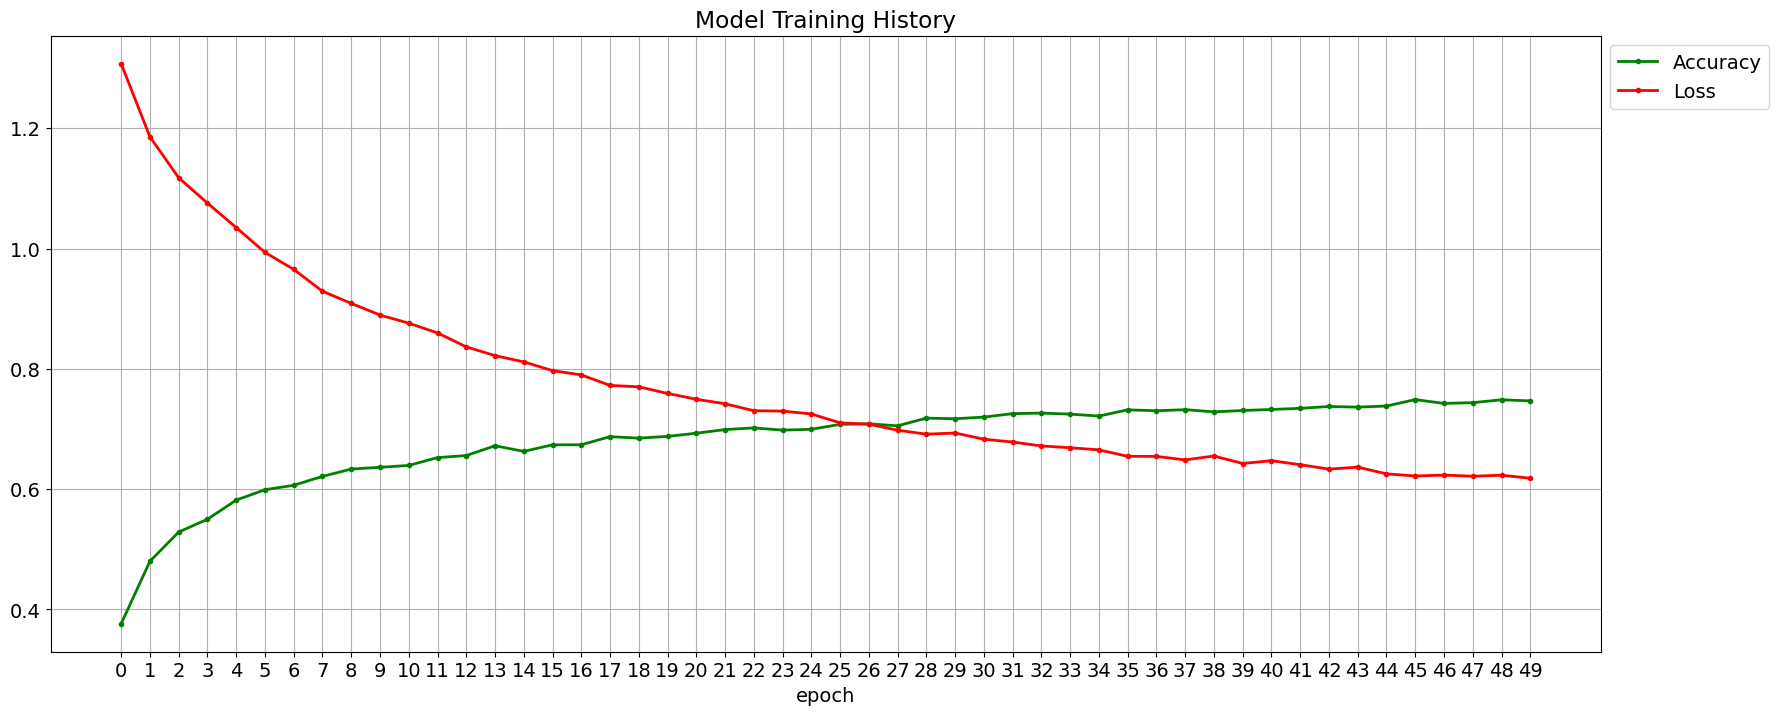

In [9]:
# Training History Plot
plt.figure(figsize=(20, 8))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
# Evaluate Model with Test Samples
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/85 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  1%|          | 1/85 [00:01<02:37,  1.87s/it]

1/1 [==============================] - 1s 501ms/step


  2%|▏         | 2/85 [00:02<01:48,  1.30s/it]

1/1 [==============================] - 0s 496ms/step


  4%|▎         | 3/85 [00:03<01:31,  1.12s/it]

1/1 [==============================] - 1s 501ms/step


  5%|▍         | 4/85 [00:04<01:22,  1.02s/it]

1/1 [==============================] - 1s 520ms/step


  6%|▌         | 5/85 [00:05<01:16,  1.04it/s]

1/1 [==============================] - 1s 570ms/step


  7%|▋         | 6/85 [00:06<01:15,  1.05it/s]

1/1 [==============================] - 1s 558ms/step


  8%|▊         | 7/85 [00:07<01:15,  1.03it/s]

1/1 [==============================] - 0s 490ms/step


  9%|▉         | 8/85 [00:08<01:12,  1.06it/s]

1/1 [==============================] - 1s 559ms/step


 11%|█         | 9/85 [00:09<01:12,  1.04it/s]

1/1 [==============================] - 1s 523ms/step


 12%|█▏        | 10/85 [00:10<01:09,  1.07it/s]

1/1 [==============================] - 1s 545ms/step


 13%|█▎        | 11/85 [00:10<01:08,  1.08it/s]

1/1 [==============================] - 1s 530ms/step


 14%|█▍        | 12/85 [00:11<01:07,  1.08it/s]

1/1 [==============================] - 1s 512ms/step


 15%|█▌        | 13/85 [00:12<01:06,  1.09it/s]

1/1 [==============================] - 1s 500ms/step


 16%|█▋        | 14/85 [00:13<01:04,  1.10it/s]

1/1 [==============================] - 1s 541ms/step


 18%|█▊        | 15/85 [00:14<01:03,  1.10it/s]

1/1 [==============================] - 0s 491ms/step


 19%|█▉        | 16/85 [00:15<01:02,  1.11it/s]

1/1 [==============================] - 0s 467ms/step


 20%|██        | 17/85 [00:16<00:58,  1.17it/s]

1/1 [==============================] - 0s 463ms/step


 21%|██        | 18/85 [00:17<00:55,  1.21it/s]

1/1 [==============================] - 0s 450ms/step


 22%|██▏       | 19/85 [00:17<00:53,  1.23it/s]

1/1 [==============================] - 0s 438ms/step


 24%|██▎       | 20/85 [00:18<00:51,  1.26it/s]

1/1 [==============================] - 0s 439ms/step


 25%|██▍       | 21/85 [00:19<00:50,  1.26it/s]

1/1 [==============================] - 0s 461ms/step


 26%|██▌       | 22/85 [00:20<00:50,  1.24it/s]

1/1 [==============================] - 0s 456ms/step


 27%|██▋       | 23/85 [00:20<00:50,  1.23it/s]

1/1 [==============================] - 1s 606ms/step


 28%|██▊       | 24/85 [00:21<00:52,  1.17it/s]

1/1 [==============================] - 1s 519ms/step


 29%|██▉       | 25/85 [00:22<00:52,  1.15it/s]

1/1 [==============================] - 0s 452ms/step


 31%|███       | 26/85 [00:23<00:50,  1.16it/s]

1/1 [==============================] - 0s 435ms/step


 32%|███▏      | 27/85 [00:24<00:49,  1.18it/s]

1/1 [==============================] - 0s 436ms/step


 33%|███▎      | 28/85 [00:25<00:47,  1.21it/s]

1/1 [==============================] - 0s 443ms/step


 34%|███▍      | 29/85 [00:26<00:45,  1.22it/s]

1/1 [==============================] - 0s 437ms/step


 35%|███▌      | 30/85 [00:26<00:44,  1.24it/s]

1/1 [==============================] - 0s 428ms/step


 36%|███▋      | 31/85 [00:27<00:42,  1.26it/s]

1/1 [==============================] - 0s 462ms/step


 38%|███▊      | 32/85 [00:28<00:42,  1.24it/s]

1/1 [==============================] - 0s 475ms/step


 39%|███▉      | 33/85 [00:29<00:41,  1.24it/s]

1/1 [==============================] - 0s 490ms/step


 40%|████      | 34/85 [00:30<00:40,  1.26it/s]

1/1 [==============================] - 0s 455ms/step


 41%|████      | 35/85 [00:30<00:40,  1.22it/s]

1/1 [==============================] - 0s 487ms/step


 42%|████▏     | 36/85 [00:32<00:44,  1.10it/s]

1/1 [==============================] - 0s 434ms/step


 44%|████▎     | 37/85 [00:32<00:42,  1.14it/s]

1/1 [==============================] - 0s 440ms/step


 45%|████▍     | 38/85 [00:33<00:39,  1.20it/s]

1/1 [==============================] - 0s 449ms/step


 46%|████▌     | 39/85 [00:34<00:37,  1.22it/s]

1/1 [==============================] - 0s 439ms/step


 47%|████▋     | 40/85 [00:35<00:36,  1.24it/s]

1/1 [==============================] - 0s 426ms/step


 48%|████▊     | 41/85 [00:35<00:33,  1.30it/s]

1/1 [==============================] - 0s 452ms/step


 49%|████▉     | 42/85 [00:36<00:33,  1.27it/s]

1/1 [==============================] - 0s 464ms/step


 51%|█████     | 43/85 [00:37<00:33,  1.26it/s]

1/1 [==============================] - 0s 449ms/step


 52%|█████▏    | 44/85 [00:38<00:32,  1.26it/s]

1/1 [==============================] - 0s 471ms/step


 53%|█████▎    | 45/85 [00:39<00:31,  1.26it/s]

1/1 [==============================] - 0s 470ms/step


 54%|█████▍    | 46/85 [00:39<00:31,  1.25it/s]

1/1 [==============================] - 0s 470ms/step


 55%|█████▌    | 47/85 [00:40<00:30,  1.25it/s]

1/1 [==============================] - 1s 517ms/step


 56%|█████▋    | 48/85 [00:41<00:30,  1.22it/s]

1/1 [==============================] - 0s 464ms/step


 58%|█████▊    | 49/85 [00:42<00:31,  1.15it/s]

1/1 [==============================] - 0s 471ms/step


 59%|█████▉    | 50/85 [00:43<00:29,  1.18it/s]

1/1 [==============================] - 0s 464ms/step


 60%|██████    | 51/85 [00:44<00:28,  1.20it/s]

1/1 [==============================] - 0s 449ms/step


 61%|██████    | 52/85 [00:44<00:27,  1.21it/s]

1/1 [==============================] - 0s 494ms/step


 62%|██████▏   | 53/85 [00:45<00:26,  1.20it/s]

1/1 [==============================] - 0s 489ms/step


 64%|██████▎   | 54/85 [00:46<00:25,  1.20it/s]

1/1 [==============================] - 0s 481ms/step


 65%|██████▍   | 55/85 [00:47<00:24,  1.23it/s]

1/1 [==============================] - 1s 519ms/step


 66%|██████▌   | 56/85 [00:48<00:23,  1.23it/s]

1/1 [==============================] - 0s 422ms/step


 67%|██████▋   | 57/85 [00:49<00:22,  1.22it/s]

1/1 [==============================] - 0s 446ms/step


 68%|██████▊   | 58/85 [00:49<00:21,  1.23it/s]

1/1 [==============================] - 0s 455ms/step


 69%|██████▉   | 59/85 [00:50<00:20,  1.24it/s]

1/1 [==============================] - 0s 466ms/step


 71%|███████   | 60/85 [00:51<00:20,  1.23it/s]

1/1 [==============================] - 0s 429ms/step


 72%|███████▏  | 61/85 [00:52<00:18,  1.28it/s]

1/1 [==============================] - 0s 430ms/step


 73%|███████▎  | 62/85 [00:52<00:17,  1.29it/s]

1/1 [==============================] - 0s 455ms/step


 74%|███████▍  | 63/85 [00:53<00:17,  1.28it/s]

1/1 [==============================] - 0s 465ms/step


 75%|███████▌  | 64/85 [00:54<00:16,  1.29it/s]

1/1 [==============================] - 0s 451ms/step


 76%|███████▋  | 65/85 [00:55<00:15,  1.29it/s]

1/1 [==============================] - 0s 461ms/step


 78%|███████▊  | 66/85 [00:56<00:14,  1.28it/s]

1/1 [==============================] - 0s 470ms/step


 79%|███████▉  | 67/85 [00:56<00:14,  1.29it/s]

1/1 [==============================] - 0s 474ms/step


 80%|████████  | 68/85 [00:57<00:13,  1.26it/s]

1/1 [==============================] - 0s 487ms/step


 81%|████████  | 69/85 [00:58<00:12,  1.26it/s]

1/1 [==============================] - 0s 433ms/step


 82%|████████▏ | 70/85 [00:59<00:12,  1.23it/s]

1/1 [==============================] - 0s 436ms/step


 84%|████████▎ | 71/85 [01:00<00:11,  1.26it/s]

1/1 [==============================] - 0s 457ms/step


 85%|████████▍ | 72/85 [01:00<00:10,  1.27it/s]

1/1 [==============================] - 0s 449ms/step


 86%|████████▌ | 73/85 [01:01<00:09,  1.28it/s]

1/1 [==============================] - 0s 456ms/step


 87%|████████▋ | 74/85 [01:02<00:08,  1.26it/s]

1/1 [==============================] - 0s 435ms/step


 88%|████████▊ | 75/85 [01:03<00:07,  1.27it/s]

1/1 [==============================] - 0s 459ms/step


 89%|████████▉ | 76/85 [01:04<00:07,  1.25it/s]

1/1 [==============================] - 0s 451ms/step


 91%|█████████ | 77/85 [01:04<00:06,  1.27it/s]

1/1 [==============================] - 0s 432ms/step


 92%|█████████▏| 78/85 [01:05<00:05,  1.30it/s]

1/1 [==============================] - 0s 453ms/step


 93%|█████████▎| 79/85 [01:06<00:04,  1.32it/s]

1/1 [==============================] - 0s 445ms/step


 94%|█████████▍| 80/85 [01:07<00:03,  1.31it/s]

1/1 [==============================] - 0s 455ms/step


 95%|█████████▌| 81/85 [01:07<00:03,  1.30it/s]

1/1 [==============================] - 0s 453ms/step


 96%|█████████▋| 82/85 [01:08<00:02,  1.29it/s]

1/1 [==============================] - 0s 471ms/step


 98%|█████████▊| 83/85 [01:09<00:01,  1.30it/s]

1/1 [==============================] - 0s 483ms/step


 99%|█████████▉| 84/85 [01:10<00:00,  1.28it/s]

1/1 [==============================] - 1s 521ms/step


100%|██████████| 85/85 [01:11<00:00,  1.23it/s]

1/1 [==============================] - 1s 1s/step


86it [01:12,  1.18it/s]                        
86it [01:12,  1.18it/s]


In [11]:
# Display classification report
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.62      0.34      0.44       686
meningioma_tumor       0.58      0.54      0.56       684
        no_tumor       0.73      0.88      0.80       683
 pituitary_tumor       0.61      0.81      0.70       692

        accuracy                           0.64      2745
       macro avg       0.64      0.64      0.62      2745
    weighted avg       0.64      0.64      0.62      2745

